# MNIST model building

In [1]:
import pickle
with open("C:/Users/User/Desktop/論文(Thesis research)/Classification with MNIST/pickled_mnist.pkl", "rb") as fh:
    data = pickle.load(fh)

train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]
train_labels_one_hot = data[4]
test_labels_one_hot = data[5]

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

print("train_imgs:", data[0].shape)
print("test_imgs:", data[1].shape)
print("train_labels:", data[2].shape)
print("test_labels:", data[3].shape)
print("train_labels_one_hot:", data[4].shape)
print("test_labels_one_hot:", data[5].shape)

train_imgs: (60000, 784)
test_imgs: (10000, 784)
train_labels: (60000, 1)
test_labels: (10000, 1)
train_labels_one_hot: (60000, 10)
test_labels_one_hot: (10000, 10)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# hidden layer activation function
# np.where(condition, x, y) :滿足條件(condition)，輸出 x，不滿足輸出 y。
def leaky_relu(z):
    return np.maximum(0.01*z,z)

def deriv_relu(dz):
    dz = np.where(dz>0, 1, 0.01)
    return dz

def sigmoid(s):
    return 1/(1 + np.exp(-s))

def deriv_sigmoid(ds):
    return ds * (1-ds)

# output layer activation_function
def stable_softmax(X):
    exps = np.exp(X.T - np.max(X, axis=1)).T
    softmax = exps.T / np.sum(exps, axis=1)
    return softmax.T

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd,
                     (upp - mean) / sd,
                     loc=mean,
                     scale=sd)

In [3]:
class NeuralNetwork():
    # ok
    def __init__(self,
                 network_structure, # ie. [input_nodes, hidden1_nodes, ... , hidden_n_nodes, output_nodes]
                 learning_rate,
                 bias=None):
        self.structure = network_structure
        self.learning_rate = learning_rate
        self.bias = bias
        self.He_weight_initialize()
        """
            # Weights 的初始化:
            if activation function :
                1. using tanh() or sigmoid(): Xavier初始化
                2. using ReLU(): Kaiming初始化(又叫作 He初始化)
        """
    def He_weight_initialize(self):
        self.weights_matrices = []
        layer_index = 1
        no_of_layers = len(self.structure)
        while layer_index < no_of_layers:     # 兩層兩層建構 weight matrices
            frontend_nodes = self.structure[layer_index-1]
            backend_nodes = self.structure[layer_index]
            bias_node = 1 if self.bias else 0    # no of bias
            w = np.random.randn((frontend_nodes + bias_node), backend_nodes)
            w_he = w * np.sqrt(2/(frontend_nodes + bias_node))
            self.weights_matrices.append(w_he)      # append() 方法用於在列表末尾添加新的對象。
            layer_index += 1


    def Forward_pass(self, train_data):
        total_layers = len(self.structure)
        if self.bias:
            no_of_bias_size = train_data.shape[0]  # 60000 samples
            bias_vector = np.ones((no_of_bias_size, 1)) * self.bias

        layer_index = 0   # forward start at 0 layer
        output_layer = total_layers -1
            # The output/input vectors of the various layers:
        self.layer_in = [train_data]
        self.deriv_of_activation = [0]

        while layer_index < output_layer:
            forward_data = self.layer_in[-1]
            if self.bias :   # input + bias
                forward_data = np.concatenate((forward_data, bias_vector), axis=1)
                self.layer_in[-1] = forward_data   # overwrite input data

            Func = np.dot(forward_data , self.weights_matrices[layer_index])
            if layer_index < output_layer-1:
                active_data = leaky_relu(Func)
                dReLU = deriv_relu(active_data)
                self.deriv_of_activation.append(dReLU)
                self.layer_in.append(active_data)
            elif layer_index == output_layer-1 :
                forward_out = stable_softmax(Func)
                #print('forward_out[1]:',forward_out[1])
                #plt.bar(range(10), forward_out[1])
                #plt.show()
            layer_index += 1
        return forward_out

    def Backward_pass(self, forward_out, label):
        total_layers = len(self.structure)
        output_layer = total_layers -1
        layer_index = output_layer    # backward start at output_layer
        target_delta = self.delta_of_cesoftmax(forward_out, label)

        while layer_index > 0:
            #out_vector = layer_in[layer_index]
            frontend_input = self.layer_in[layer_index-1]

            if layer_index == output_layer:
                gradi = np.dot(target_delta.T , frontend_input)    # gradi = delta * input
                # error 為 BP 下一層的輸入
                self.error = np.dot(target_delta , self.weights_matrices[layer_index-1].T)
                self.weights_matrices[layer_index-1] -= gradi.T * self.learning_rate
                print("[finish output BP iteration]")

            elif layer_index < output_layer:
                delta = self.error * self.deriv_of_activation[layer_index]
                gradi = np.dot(delta.T , frontend_input)     # delta * input
                # error * activation_derivative
                if layer_index > 1:
                    self.error = np.dot(delta , self.weights_matrices[layer_index-1].T)
                self.weights_matrices[layer_index-1] -= gradi.T * self.learning_rate
                print("[finish hidden BP iteration]")

            if self.bias:  # 如果有 bias
                self.error = self.error[:,:-1]  # 拿掉 bias 再往回傳 (bias為行向量最後一行)
            layer_index -= 1
        return self.weights_matrices


    def train(self, train_data, labels_one_hot_array, epochs= 1):
        loss_list = []
        epoch_list = []
        for epoch in range(epochs):
            print("====> Epoch ==> ", epoch)
            forward_out = self.Forward_pass(train_data)
            print('forward_out:',forward_out.shape)
            print('labels_one_hot_array:',labels_one_hot_array.shape)
            cost = self.cross_entropy(forward_out, labels_one_hot_array)
            self.Backward_pass(forward_out, labels_one_hot_array)
            print("====> Cost ==> ", cost)
            epoch_list.append(epoch)
            loss_list.append(cost)
            print("-------------------------------------")

        plt.plot(epoch_list , loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.show()
        """
        for epoch in range(epochs):
            for i in range(len(data_array)):
                self.train_single(data_array[i], labels_one_hot_array[i])
        """
    def cross_entropy(self, predi, label):
        log_loss = np.sum((label*np.log(predi)),axis=1)
        cost = -np.mean(log_loss)
        return cost

    def delta_of_cesoftmax(self, predi, label):
        gradi = predi - label
        return gradi / label.shape[0]

    def evaluate(self, data, labels):    # material_data can be training or testing dataset
        corrects, wrongs = 0, 0
        res = self.Forward_pass(data)
        for i in range(len(data)):
            res_max = np.argmax(res[i])    # np.argmax() 返回最大值 index
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

    """
    corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", corrects / ( corrects + wrongs))
    corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
    print("accuracy: test", corrects / ( corrects + wrongs))
    """

====> Epoch ==>  0
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  2.328927528714228
-------------------------------------
====> Epoch ==>  1
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  2.2084275910035673
-------------------------------------
====> Epoch ==>  2
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  2.12457262397187
-------------------------------------
====> Epoch ==>  3
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  2.048348268921145
-------------------------------------
====> Epoch ==>  4
forward_out: (60000, 10)
labels_o

====> Cost ==>  0.6673643022068078
-------------------------------------
====> Epoch ==>  35
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.6550147601709215
-------------------------------------
====> Epoch ==>  36
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.6433639646137436
-------------------------------------
====> Epoch ==>  37
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.6323537061381732
-------------------------------------
====> Epoch ==>  38
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.6219323997319735
---------

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.4512198785598234
-------------------------------------
====> Epoch ==>  70
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.448277609538864
-------------------------------------
====> Epoch ==>  71
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.4454180950455301
-------------------------------------
====> Epoch ==>  72
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.4426381861977228
-------------------------------------
====> Epoch ==>  73
forward_out: (60000, 10)
labels_one_hot_array

[finish hidden BP iteration]
====> Cost ==>  0.3824277281769657
-------------------------------------
====> Epoch ==>  104
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.3810429911576931
-------------------------------------
====> Epoch ==>  105
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.37968203891870594
-------------------------------------
====> Epoch ==>  106
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.37834392058520044
-------------------------------------
====> Epoch ==>  107
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cos

[finish hidden BP iteration]
====> Cost ==>  0.34532492824060906
-------------------------------------
====> Epoch ==>  138
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.34446558777126984
-------------------------------------
====> Epoch ==>  139
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.34361578251100405
-------------------------------------
====> Epoch ==>  140
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.34277551368248854
-------------------------------------
====> Epoch ==>  141
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> C

====> Cost ==>  0.3205688923997528
-------------------------------------
====> Epoch ==>  172
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.3199534466177673
-------------------------------------
====> Epoch ==>  173
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.31934313255131114
-------------------------------------
====> Epoch ==>  174
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.31873745484099447
-------------------------------------
====> Epoch ==>  175
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.3181364862407492
---

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.30160247755394287
-------------------------------------
====> Epoch ==>  207
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.30112630780095634
-------------------------------------
====> Epoch ==>  208
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.3006531022704653
-------------------------------------
====> Epoch ==>  209
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.3001825384848556
-------------------------------------
====> Epoch ==>  210
forward_out: (60000, 10)
labels_one_ho

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2865125819373952
-------------------------------------
====> Epoch ==>  242
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.28612221923941805
-------------------------------------
====> Epoch ==>  243
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.28573366990624305
-------------------------------------
====> Epoch ==>  244
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2853471489706535
-------------------------------------
====> Epoch ==>  245
forward_out: (60000, 10)
labels_one_ho

[finish hidden BP iteration]
====> Cost ==>  0.27417477668274975
-------------------------------------
====> Epoch ==>  276
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2738379534204801
-------------------------------------
====> Epoch ==>  277
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2735024998721099
-------------------------------------
====> Epoch ==>  278
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.27316820290339716
-------------------------------------
====> Epoch ==>  279
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cos

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.26306280972311713
-------------------------------------
====> Epoch ==>  311
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2627634069638072
-------------------------------------
====> Epoch ==>  312
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2624649194707069
-------------------------------------
====> Epoch ==>  313
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2621676425608489
-------------------------------------
====> Epoch ==>  314
forward_out: (60000, 10)
labels_one_hot

[finish hidden BP iteration]
====> Cost ==>  0.2533564891849943
-------------------------------------
====> Epoch ==>  345
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.253084602583662
-------------------------------------
====> Epoch ==>  346
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.25281338645720436
-------------------------------------
====> Epoch ==>  347
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2525427724495004
-------------------------------------
====> Epoch ==>  348
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost 

[finish hidden BP iteration]
====> Cost ==>  0.24452043389034162
-------------------------------------
====> Epoch ==>  379
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2442723858013559
-------------------------------------
====> Epoch ==>  380
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.24402497160439005
-------------------------------------
====> Epoch ==>  381
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2437781353130027
-------------------------------------
====> Epoch ==>  382
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cos

====> Cost ==>  0.23644793930573949
-------------------------------------
====> Epoch ==>  413
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.23622077664916147
-------------------------------------
====> Epoch ==>  414
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.23599398583230746
-------------------------------------
====> Epoch ==>  415
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.23576790269090853
-------------------------------------
====> Epoch ==>  416
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.23554241898643086


forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.22883133035423917
-------------------------------------
====> Epoch ==>  448
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.22862279431317847
-------------------------------------
====> Epoch ==>  449
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2284147912424735
-------------------------------------
====> Epoch ==>  450
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.22820732434594254
-------------------------------------
====> Epoch ==>  451
forward_out: (60000, 10)
labels_one_h

[finish hidden BP iteration]
====> Cost ==>  0.22196048142931635
-------------------------------------
====> Epoch ==>  482
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.22176537452177464
-------------------------------------
====> Epoch ==>  483
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.22157068877837025
-------------------------------------
====> Epoch ==>  484
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2213763441412043
-------------------------------------
====> Epoch ==>  485
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Co

[finish hidden BP iteration]
====> Cost ==>  0.21552291080011052
-------------------------------------
====> Epoch ==>  516
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2153394605833292
-------------------------------------
====> Epoch ==>  517
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.21515631423873433
-------------------------------------
====> Epoch ==>  518
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2149734609014406
-------------------------------------
====> Epoch ==>  519
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cos

====> Cost ==>  0.20944049880593377
-------------------------------------
====> Epoch ==>  550
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2092663000920031
-------------------------------------
====> Epoch ==>  551
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.20909241623768746
-------------------------------------
====> Epoch ==>  552
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.20891875726570375
-------------------------------------
====> Epoch ==>  553
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.20874529618829257
-

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.20350691224761794
-------------------------------------
====> Epoch ==>  585
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.20334227268559904
-------------------------------------
====> Epoch ==>  586
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.20317796857908374
-------------------------------------
====> Epoch ==>  587
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.2030139149609427
-------------------------------------
====> Epoch ==>  588
forward_out: (60000, 10)
labels_one_h

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.19789790729300205
-------------------------------------
====> Epoch ==>  620
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1977425218361404
-------------------------------------
====> Epoch ==>  621
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.19758737362479994
-------------------------------------
====> Epoch ==>  622
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.19743248808316988
-------------------------------------
====> Epoch ==>  623
forward_out: (60000, 10)
labels_one_h

[finish hidden BP iteration]
====> Cost ==>  0.19274728087434712
-------------------------------------
====> Epoch ==>  654
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.19260039113089827
-------------------------------------
====> Epoch ==>  655
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.19245370862358913
-------------------------------------
====> Epoch ==>  656
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.19230731217803762
-------------------------------------
====> Epoch ==>  657
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> C

[finish hidden BP iteration]
====> Cost ==>  0.18787804744270045
-------------------------------------
====> Epoch ==>  688
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.18773914250591758
-------------------------------------
====> Epoch ==>  689
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.18760044304277756
-------------------------------------
====> Epoch ==>  690
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.18746188229410482
-------------------------------------
====> Epoch ==>  691
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> C

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1831427763093657
-------------------------------------
====> Epoch ==>  723
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.18301109715731884
-------------------------------------
====> Epoch ==>  724
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.18287961628415583
-------------------------------------
====> Epoch ==>  725
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1827483813059844
-------------------------------------
====> Epoch ==>  726
forward_out: (60000, 10)
labels_one_ho

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17865205239686022
-------------------------------------
====> Epoch ==>  758
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1785276259109076
-------------------------------------
====> Epoch ==>  759
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17840336619032768
-------------------------------------
====> Epoch ==>  760
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17827926914889183
-------------------------------------
====> Epoch ==>  761
forward_out: (60000, 10)
labels_one_h

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17440039380326153
-------------------------------------
====> Epoch ==>  793
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1742823326663716
-------------------------------------
====> Epoch ==>  794
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17416442571270058
-------------------------------------
====> Epoch ==>  795
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17404669653480456
-------------------------------------
====> Epoch ==>  796
forward_out: (60000, 10)
labels_one_h

[finish hidden BP iteration]
====> Cost ==>  0.1704933045393293
-------------------------------------
====> Epoch ==>  827
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1703815959929719
-------------------------------------
====> Epoch ==>  828
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.170270037644722
-------------------------------------
====> Epoch ==>  829
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.17015863459137748
-------------------------------------
====> Epoch ==>  830
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost 

[finish hidden BP iteration]
====> Cost ==>  0.1667789284530228
-------------------------------------
====> Epoch ==>  861
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.16667195957565575
-------------------------------------
====> Epoch ==>  862
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.16656503832914554
-------------------------------------
====> Epoch ==>  863
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.16645834792916367
-------------------------------------
====> Epoch ==>  864
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Co

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.16311387970938043
-------------------------------------
====> Epoch ==>  896
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1630116162667787
-------------------------------------
====> Epoch ==>  897
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1629094983137884
-------------------------------------
====> Epoch ==>  898
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.16280745585322623
-------------------------------------
====> Epoch ==>  899
forward_out: (60000, 10)
labels_one_ho

[finish hidden BP iteration]
====> Cost ==>  0.15970659298906367
-------------------------------------
====> Epoch ==>  930
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1596086141563692
-------------------------------------
====> Epoch ==>  931
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1595107534749377
-------------------------------------
====> Epoch ==>  932
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15941302700497995
-------------------------------------
====> Epoch ==>  933
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cos

[finish hidden BP iteration]
====> Cost ==>  0.1564417972952619
-------------------------------------
====> Epoch ==>  964
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15634792570201542
-------------------------------------
====> Epoch ==>  965
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15625424168673308
-------------------------------------
====> Epoch ==>  966
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1561607824237578
-------------------------------------
====> Epoch ==>  967
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cos

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15323114583872666
-------------------------------------
====> Epoch ==>  999
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1531414303409335
-------------------------------------
====> Epoch ==>  1000
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15305174959964044
-------------------------------------
====> Epoch ==>  1001
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1529621864384449
-------------------------------------
====> Epoch ==>  1002
forward_out: (60000, 10)
labels_one

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15023954372379844
-------------------------------------
====> Epoch ==>  1033
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15015355164760336
-------------------------------------
====> Epoch ==>  1034
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.15006766908523722
-------------------------------------
====> Epoch ==>  1035
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14998186075581227
-------------------------------------
====> Epoch ==>  1036
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14737393989539035
-------------------------------------
====> Epoch ==>  1067
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14729141512678204
-------------------------------------
====> Epoch ==>  1068
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14720898843730038
-------------------------------------
====> Epoch ==>  1069
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14712664639316764
-------------------------------------
====> Epoch ==>  1070
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14461717111744146
-------------------------------------
====> Epoch ==>  1101
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14453761136752571
-------------------------------------
====> Epoch ==>  1102
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14445812340395126
-------------------------------------
====> Epoch ==>  1103
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1443787513933491
-------------------------------------
====> Epoch ==>  1104
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1419603968428976
-------------------------------------
====> Epoch ==>  1135
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14188381119357568
-------------------------------------
====> Epoch ==>  1136
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.14180732890881265
-------------------------------------
====> Epoch ==>  1137
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1417309064642682
-------------------------------------
====> Epoch ==>  1138
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1394038128859991
-------------------------------------
====> Epoch ==>  1169
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1393299865917537
-------------------------------------
====> Epoch ==>  1170
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13925623271787474
-------------------------------------
====> Epoch ==>  1171
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13918256752395972
-------------------------------------
====> Epoch ==>  1172
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13693365589912526
-------------------------------------
====> Epoch ==>  1203
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13686230789368056
-------------------------------------
====> Epoch ==>  1204
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13679101200728985
-------------------------------------
====> Epoch ==>  1205
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1367197968652813
-------------------------------------
====> Epoch ==>  1206
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13455013143402242
-------------------------------------
====> Epoch ==>  1237
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13448146114150453
-------------------------------------
====> Epoch ==>  1238
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13441288717094874
-------------------------------------
====> Epoch ==>  1239
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1343444034197451
-------------------------------------
====> Epoch ==>  1240
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1322569543486232
-------------------------------------
====> Epoch ==>  1271
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13219059777548345
-------------------------------------
====> Epoch ==>  1272
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13212432800900642
-------------------------------------
====> Epoch ==>  1273
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.13205813193560556
-------------------------------------
====> Epoch ==>  1274
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1300364296384081
-------------------------------------
====> Epoch ==>  1305
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12997212884593357
-------------------------------------
====> Epoch ==>  1306
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1299078464619082
-------------------------------------
====> Epoch ==>  1307
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12984362649919914
-------------------------------------
====> Epoch ==>  1308
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12788982222008832
-------------------------------------
====> Epoch ==>  1339
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1278277131542593
-------------------------------------
====> Epoch ==>  1340
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1277656585798486
-------------------------------------
====> Epoch ==>  1341
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1277036566336072
-------------------------------------
====> Epoch ==>  1342
forward_out: (60000, 10)
labels_one

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1258120830865834
-------------------------------------
====> Epoch ==>  1373
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1257519649535557
-------------------------------------
====> Epoch ==>  1374
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1256919128693131
-------------------------------------
====> Epoch ==>  1375
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12563191607739202
-------------------------------------
====> Epoch ==>  1376
forward_out: (60000, 10)
labels_one

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12379670759799122
-------------------------------------
====> Epoch ==>  1407
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1237383397711495
-------------------------------------
====> Epoch ==>  1408
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12368006136557423
-------------------------------------
====> Epoch ==>  1409
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12362181988460855
-------------------------------------
====> Epoch ==>  1410
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12184263896237092
-------------------------------------
====> Epoch ==>  1441
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12178608180837855
-------------------------------------
====> Epoch ==>  1442
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12172957378227843
-------------------------------------
====> Epoch ==>  1443
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.12167311126111806
-------------------------------------
====> Epoch ==>  1444
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11994786415718768
-------------------------------------
====> Epoch ==>  1475
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11989316773997452
-------------------------------------
====> Epoch ==>  1476
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11983850006809654
-------------------------------------
====> Epoch ==>  1477
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11978385126862652
-------------------------------------
====> Epoch ==>  1478
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11811527660274078
-------------------------------------
====> Epoch ==>  1509
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11806222561718892
-------------------------------------
====> Epoch ==>  1510
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11800920522515455
-------------------------------------
====> Epoch ==>  1511
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11795622677831967
-------------------------------------
====> Epoch ==>  1512
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11633744651785176
-------------------------------------
====> Epoch ==>  1543
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11628598977211814
-------------------------------------
====> Epoch ==>  1544
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11623458749744561
-------------------------------------
====> Epoch ==>  1545
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11618323930777419
-------------------------------------
====> Epoch ==>  1546
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11460872468645568
-------------------------------------
====> Epoch ==>  1577
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11455858837949767
-------------------------------------
====> Epoch ==>  1578
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11450849541643403
-------------------------------------
====> Epoch ==>  1579
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11445848804426424
-------------------------------------
====> Epoch ==>  1580
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1129307302243263
-------------------------------------
====> Epoch ==>  1611
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11288212643959294
-------------------------------------
====> Epoch ==>  1612
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11283357040494829
-------------------------------------
====> Epoch ==>  1613
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11278504793145092
-------------------------------------
====> Epoch ==>  1614
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1112994337292911
-------------------------------------
====> Epoch ==>  1645
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11125212542739715
-------------------------------------
====> Epoch ==>  1646
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11120484438519695
-------------------------------------
====> Epoch ==>  1647
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.11115762487379828
-------------------------------------
====> Epoch ==>  1648
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10971121932292612
-------------------------------------
====> Epoch ==>  1679
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10966516177092925
-------------------------------------
====> Epoch ==>  1680
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10961915580155172
-------------------------------------
====> Epoch ==>  1681
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10957318426172054
-------------------------------------
====> Epoch ==>  1682
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10816458045060383
-------------------------------------
====> Epoch ==>  1713
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10811972545368646
-------------------------------------
====> Epoch ==>  1714
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10807490783379663
-------------------------------------
====> Epoch ==>  1715
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10803012026550031
-------------------------------------
====> Epoch ==>  1716
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10665931871944614
-------------------------------------
====> Epoch ==>  1747
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10661561642152007
-------------------------------------
====> Epoch ==>  1748
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10657195954372153
-------------------------------------
====> Epoch ==>  1749
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10652830818878156
-------------------------------------
====> Epoch ==>  1750
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10519012369340959
-------------------------------------
====> Epoch ==>  1781
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10514740395460778
-------------------------------------
====> Epoch ==>  1782
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10510470072567148
-------------------------------------
====> Epoch ==>  1783
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1050620235225242
-------------------------------------
====> Epoch ==>  1784
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10375617721101663
-------------------------------------
====> Epoch ==>  1815
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10371458888118425
-------------------------------------
====> Epoch ==>  1816
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10367304005556864
-------------------------------------
====> Epoch ==>  1817
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10363149731978853
-------------------------------------
====> Epoch ==>  1818
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10235698755859568
-------------------------------------
====> Epoch ==>  1849
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.1023163660312812
-------------------------------------
====> Epoch ==>  1850
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10227577195140591
-------------------------------------
====> Epoch ==>  1851
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10223523048961274
-------------------------------------
====> Epoch ==>  1852
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10099477949564614
-------------------------------------
====> Epoch ==>  1883
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10095523185149001
-------------------------------------
====> Epoch ==>  1884
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10091572075717492
-------------------------------------
====> Epoch ==>  1885
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.10087624354694166
-------------------------------------
====> Epoch ==>  1886
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09966474297500741
-------------------------------------
====> Epoch ==>  1917
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09962606792344665
-------------------------------------
====> Epoch ==>  1918
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09958740637110351
-------------------------------------
====> Epoch ==>  1919
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09954876395539154
-------------------------------------
====> Epoch ==>  1920
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09836545353769283
-------------------------------------
====> Epoch ==>  1951
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09832770303263313
-------------------------------------
====> Epoch ==>  1952
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09828998348410313
-------------------------------------
====> Epoch ==>  1953
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09825230901995956
-------------------------------------
====> Epoch ==>  1954
forward_out: (60000, 10)
labels_

====> Epoch ==>  1984
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09709758842840613
-------------------------------------
====> Epoch ==>  1985
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09706072859153174
-------------------------------------
====> Epoch ==>  1986
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0970238991001944
-------------------------------------
====> Epoch ==>  1987
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09698708883570883
-------------------------------------
====> Epoch ==>  1988
forward_out

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09586018424930152
-------------------------------------
====> Epoch ==>  2019
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09582424954187883
-------------------------------------
====> Epoch ==>  2020
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09578832802525508
-------------------------------------
====> Epoch ==>  2021
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09575243553205194
-------------------------------------
====> Epoch ==>  2022
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09465423189541745
-------------------------------------
====> Epoch ==>  2053
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09461926645469068
-------------------------------------
====> Epoch ==>  2054
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09458433858469621
-------------------------------------
====> Epoch ==>  2055
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09454941868752638
-------------------------------------
====> Epoch ==>  2056
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09347629354161649
-------------------------------------
====> Epoch ==>  2087
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09344196339769294
-------------------------------------
====> Epoch ==>  2088
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09340766557536974
-------------------------------------
====> Epoch ==>  2089
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09337338967072982
-------------------------------------
====> Epoch ==>  2090
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09232250514669603
-------------------------------------
====> Epoch ==>  2121
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0922889535877798
-------------------------------------
====> Epoch ==>  2122
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0922554312012245
-------------------------------------
====> Epoch ==>  2123
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09222193062273823
-------------------------------------
====> Epoch ==>  2124
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09119234322657521
-------------------------------------
====> Epoch ==>  2155
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09115945752317048
-------------------------------------
====> Epoch ==>  2156
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0911265774209891
-------------------------------------
====> Epoch ==>  2157
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09109372996745997
-------------------------------------
====> Epoch ==>  2158
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0900870835337022
-------------------------------------
====> Epoch ==>  2189
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09005496393155635
-------------------------------------
====> Epoch ==>  2190
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.09002286027699426
-------------------------------------
====> Epoch ==>  2191
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0899907857384687
-------------------------------------
====> Epoch ==>  2192
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08900747404891463
-------------------------------------
====> Epoch ==>  2223
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08897606495431738
-------------------------------------
====> Epoch ==>  2224
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08894467714732633
-------------------------------------
====> Epoch ==>  2225
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08891330397821198
-------------------------------------
====> Epoch ==>  2226
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08794943305136306
-------------------------------------
====> Epoch ==>  2257
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08791859072025407
-------------------------------------
====> Epoch ==>  2258
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08788777050398051
-------------------------------------
====> Epoch ==>  2259
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08785698104858922
-------------------------------------
====> Epoch ==>  2260
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08691190662325268
-------------------------------------
====> Epoch ==>  2291
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08688179704290037
-------------------------------------
====> Epoch ==>  2292
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08685170720462715
-------------------------------------
====> Epoch ==>  2293
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0868216346368191
-------------------------------------
====> Epoch ==>  2294
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08589895701250046
-------------------------------------
====> Epoch ==>  2325
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08586948634598503
-------------------------------------
====> Epoch ==>  2326
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08584003526765165
-------------------------------------
====> Epoch ==>  2327
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08581061051832996
-------------------------------------
====> Epoch ==>  2328
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0849083517013137
-------------------------------------
====> Epoch ==>  2359
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0848795432777401
-------------------------------------
====> Epoch ==>  2360
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08485075619184655
-------------------------------------
====> Epoch ==>  2361
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08482198049917913
-------------------------------------
====> Epoch ==>  2362
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08394066565957582
-------------------------------------
====> Epoch ==>  2393
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08391254989437204
-------------------------------------
====> Epoch ==>  2394
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08388444301137016
-------------------------------------
====> Epoch ==>  2395
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08385637537850647
-------------------------------------
====> Epoch ==>  2396
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08299270676326774
-------------------------------------
====> Epoch ==>  2427
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08296502471096136
-------------------------------------
====> Epoch ==>  2428
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08293736229231483
-------------------------------------
====> Epoch ==>  2429
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08290968619564293
-------------------------------------
====> Epoch ==>  2430
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08205832859761077
-------------------------------------
====> Epoch ==>  2461
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08203104679160085
-------------------------------------
====> Epoch ==>  2462
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08200377396955347
-------------------------------------
====> Epoch ==>  2463
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0819765306464588
-------------------------------------
====> Epoch ==>  2464
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08114026144861994
-------------------------------------
====> Epoch ==>  2495
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0811135956245423
-------------------------------------
====> Epoch ==>  2496
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08108694466599853
-------------------------------------
====> Epoch ==>  2497
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08106028336217669
-------------------------------------
====> Epoch ==>  2498
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08024178307130349
-------------------------------------
====> Epoch ==>  2529
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0802156278451648
-------------------------------------
====> Epoch ==>  2530
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08018949518559863
-------------------------------------
====> Epoch ==>  2531
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.08016338338534992
-------------------------------------
====> Epoch ==>  2532
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07936065540082242
-------------------------------------
====> Epoch ==>  2563
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07933502821884487
-------------------------------------
====> Epoch ==>  2564
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07930943128382789
-------------------------------------
====> Epoch ==>  2565
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0792838621971284
-------------------------------------
====> Epoch ==>  2566
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07849870500772316
-------------------------------------
====> Epoch ==>  2597
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0784736329797615
-------------------------------------
====> Epoch ==>  2598
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07844857166636111
-------------------------------------
====> Epoch ==>  2599
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07842357062583544
-------------------------------------
====> Epoch ==>  2600
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07765587962460338
-------------------------------------
====> Epoch ==>  2631
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07763136132023998
-------------------------------------
====> Epoch ==>  2632
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0776068533173771
-------------------------------------
====> Epoch ==>  2633
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0775823669417329
-------------------------------------
====> Epoch ==>  2634
forward_out: (60000, 10)
labels_on

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07682804519013997
-------------------------------------
====> Epoch ==>  2665
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07680391408092871
-------------------------------------
====> Epoch ==>  2666
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07677977649310438
-------------------------------------
====> Epoch ==>  2667
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07675567394071889
-------------------------------------
====> Epoch ==>  2668
forward_out: (60000, 10)
labels_

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07601414446166242
-------------------------------------
====> Epoch ==>  2699
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07599042363784995
-------------------------------------
====> Epoch ==>  2700
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0759667114250944
-------------------------------------
====> Epoch ==>  2701
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07594299074930402
-------------------------------------
====> Epoch ==>  2702
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07521328760089241
-------------------------------------
====> Epoch ==>  2733
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07518991454511231
-------------------------------------
====> Epoch ==>  2734
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07516652572999319
-------------------------------------
====> Epoch ==>  2735
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0751431485507169
-------------------------------------
====> Epoch ==>  2736
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07442446222899814
-------------------------------------
====> Epoch ==>  2767
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0744014949074783
-------------------------------------
====> Epoch ==>  2768
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07437849338180837
-------------------------------------
====> Epoch ==>  2769
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07435552022018213
-------------------------------------
====> Epoch ==>  2770
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07364864427824078
-------------------------------------
====> Epoch ==>  2801
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07362602950642597
-------------------------------------
====> Epoch ==>  2802
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07360340030407428
-------------------------------------
====> Epoch ==>  2803
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0735808083958735
-------------------------------------
====> Epoch ==>  2804
forward_out: (60000, 10)
labels_o

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07288580552132898
-------------------------------------
====> Epoch ==>  2835
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07286358935920574
-------------------------------------
====> Epoch ==>  2836
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07284137481799083
-------------------------------------
====> Epoch ==>  2837
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07281918601780568
-------------------------------------
====> Epoch ==>  2838
forward_out: (60000, 10)
labels_

-------------------------------------
====> Epoch ==>  2868
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07213693067823002
-------------------------------------
====> Epoch ==>  2869
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07211511980747744
-------------------------------------
====> Epoch ==>  2870
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07209330567184978
-------------------------------------
====> Epoch ==>  2871
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07207151699806115
--------------------------------

====> Cost ==>  0.07142348149705814
-------------------------------------
====> Epoch ==>  2902
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07140201646127062
-------------------------------------
====> Epoch ==>  2903
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07138059780575501
-------------------------------------
====> Epoch ==>  2904
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07135916596076329
-------------------------------------
====> Epoch ==>  2905
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07133774870340

[finish hidden BP iteration]
====> Cost ==>  0.07070041068327101
-------------------------------------
====> Epoch ==>  2936
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07067932170677275
-------------------------------------
====> Epoch ==>  2937
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.0706582485425442
-------------------------------------
====> Epoch ==>  2938
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.07063717120535391
-------------------------------------
====> Epoch ==>  2939
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====

forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.06996876525691945
-------------------------------------
====> Epoch ==>  2971
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.06994803962785402
-------------------------------------
====> Epoch ==>  2972
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.06992733171973994
-------------------------------------
====> Epoch ==>  2973
forward_out: (60000, 10)
labels_one_hot_array: (60000, 10)
[finish output BP iteration]
[finish hidden BP iteration]
[finish hidden BP iteration]
====> Cost ==>  0.06990662956304144
-------------------------------------
====> Epoch ==>  2974
forward_out: (60000, 10)
labels_

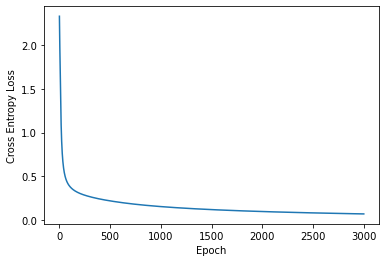

In [4]:
ANN = NeuralNetwork(network_structure=[image_pixels, 80, 80, 10], learning_rate=0.1, bias=0.1)
ANN.train(train_imgs, train_labels_one_hot, epochs= 3000)

In [5]:
res = ANN.Forward_pass(test_imgs)
for i in range(20):
    print(test_labels[i], np.argmax(res[i]), np.max(res[i]))

[7.] 7 0.999046695852735
[2.] 2 0.9996095911234197
[1.] 1 0.9905362157986127
[0.] 0 0.9997057498575186
[4.] 4 0.9916480133759472
[1.] 1 0.9961644425910495
[4.] 4 0.9954354031401677
[9.] 9 0.9885813673690462
[5.] 6 0.9700850442543654
[9.] 9 0.9949132576947521
[0.] 0 0.9992332112932173
[6.] 6 0.9959792818235766
[9.] 9 0.9973030471558935
[0.] 0 0.9942335539640186
[1.] 1 0.9996958081191493
[5.] 5 0.9421533411802786
[9.] 9 0.9956275030119999
[7.] 7 0.998763596789977
[3.] 3 0.9287336989841295
[4.] 4 0.9998858648536666


In [6]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy test:", corrects / ( corrects + wrongs))

accuracy train:  0.9812166666666666
accuracy test: 0.97
